In [20]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from torch.utils.data import DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Use device {device}")

Use device cpu


### Generate data

In [2]:
class DataModule():
    def __init__(self, num_observatiosn=2000, batch_size=128, num_workers=2, is_train=True):
        self.N = num_observatiosn
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.is_train = is_train

    def generate_orgin(self, batch_size: int) -> torch.Tensor:
        """Generate original data."""
        raise NotImplementedError

    def _generate_data(self, iterations=3):
        self.origin = self.generate_orgin(self.N)
        d = self.origin.clone()
        w_size = d.shape[1]
        for i in range(iterations):
            W = np.random.uniform(-1, 1, size=(w_size, w_size))
            d = torch.tanh(d @ W)
        self.data = d.to(torch.float32)

    def get_dataloader(self, iterations=3):
        self._generate_data(iterations=iterations)
        return DataLoader((self.data, self.generate_orgin(self.N)), batch_size=self.batch_size, \
                          num_workers=self.num_workers, shuffle=self.is_train)
    
    def show_distribution(self, data: torch.Tensor, nrows: int, ncols: int):
        assert data.shape[1] == nrows*ncols, "The number of subplots does not match the number of data."
        fig, axs = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))
        axs = axs.reshape((nrows, ncols))
        for r in range(nrows):
            for c in range(ncols):
                idx = r * ncols + c
                sns.histplot(data[:, idx], ax=axs[r, c])


class Data_dim2(DataModule):
    def __init__(self, num_observatiosn=2000, batch_size=128, num_workers=2, is_train=True):
        super().__init__(num_observatiosn, batch_size, num_workers, is_train)
    
    def generate_orgin(self, batch_size) -> torch.Tensor:
        size = (batch_size, 1)
        d1 = np.random.uniform(-1, 1, size)
        d2 = np.random.exponential(1, size)
        origin = torch.tensor(np.concatenate([d1, d2], axis=1), dtype=torch.float32)
        return origin

### MMD
Can consider use multiple kernels in the MMD-GAN

In [3]:
def rbf_kernel(X, Y, gamma):
    """
    Calculate the RBF kernel of the given data X and Y
    
    Args
    ----
    X, Y: torch.Tensor
        The target data
    gamma: float
        Inverse of the bandwidth (1/sigma)
        
    Returns
    -------
    """
    assert X.shape[1] == Y.shape[1], "The data should have the same dimension."

    # Calculate the Euclidean distance between the every pair of data in X and Y
    K = ((X[: ,np.newaxis, :] - Y[np.newaxis, :, :])**2).sum(axis=2)
    if gamma is None:
        gamma = 1.0 / X.shape[1]
    
    K *= -gamma 
    return torch.exp(K)

def mmd2(X, Y, kernel=rbf_kernel, gamma=10):
    K_xx, K_xy, K_yy = kernel(X, X, gamma), kernel(X, Y, gamma), kernel(Y, Y, gamma)
    n = X.shape[0]
    numerator = n * (n - 1)
    return K_xx.sum() / numerator - (2*K_xy.sum())  / numerator + K_yy.sum() / numerator

def mmd(X, Y, kernel=rbf_kernel, **kwargs):
    return mmd2(X, Y, kernel, **kwargs)**(0.5)

### Network

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, input_size),
        )
    
    def __getitem__(self, idx):
        return self.net[idx]
    
    def forward(self, X):
        return self.net(X)

def weight_init(m: nn.Module):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight.data)

def get_net(input_size):
    net = Encoder(input_size=input_size).to(device)
    net.apply(weight_init)
    return net

### Train

In [5]:
batch_size = 256
data = Data_dim2(num_observatiosn=2000, batch_size=batch_size)
train_loader = data.get_dataloader(3)
num_epochs = 1000
loss = mmd

In [16]:
def train(num_epochs, train_loader, device, loss, net, lr, gamma, wd=0, betas=(0.9, 0.999), savefig=None, verbose=False):
    # configure optimizer
    optimizer = torch.optim.Adam(net.parameters(), betas=betas,lr=lr, weight_decay=wd)

    loss_list = []
    for epoch in range(num_epochs):
        for X, y in train_loader:
            X, y = X.to(device=device), y.to(device=device)
            l = loss(net(X), net(y), gamma=gamma)
            l.backward()
            optimizer.step()
        
            loss_list.append(l.item())

        if verbose and (epoch + 1) % 10 == 0:
            print(f'[{epoch+1}/{num_epochs}] Loss: {loss_list[-1]}')
            
    loss_fig = sns.lineplot(data=loss_list)
    if savefig is not None:
        loss_fig.get_figure().savefig(savefig)

In [23]:
# The hyper parameter to be adjusted
gammas = [1, 10, 100, 1000]
lrs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]
# for lr in lrs:
#     for gamma in gammas:
#         net = get_net(data.data.shape[1])
#         train(num_epochs, train_loader, device, loss, net, lr=lr, gamma=gamma)
        

In [24]:
for lr in lrs:
    for gamma in gammas:
        print(str(lr)+'|'+str(gamma))

1e-05|1
1e-05|10
1e-05|100
1e-05|1000
0.0001|1
0.0001|10
0.0001|100
0.0001|1000
0.001|1
0.001|10
0.001|100
0.001|1000
0.01|1
0.01|10
0.01|100
0.01|1000
0.1|1
0.1|10
0.1|100
0.1|1000
1|1
1|10
1|100
1|1000


In [10]:
with torch.no_grad():
    y = net(data.data.to(device=device))
y

tensor([[-59.9308,  58.1363],
        [ 22.7123,  -6.1160],
        [ -8.6335,  16.9200],
        ...,
        [ -5.7260,  14.7893],
        [-37.9868,  39.9134],
        [ 27.8415,  -9.9914]])

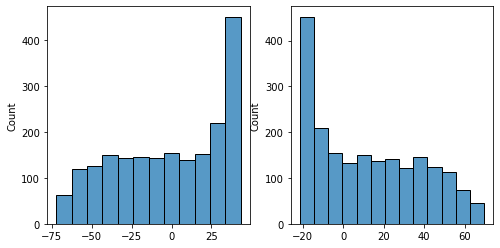

In [11]:
data.show_distribution(y.cpu(), 1, 2)

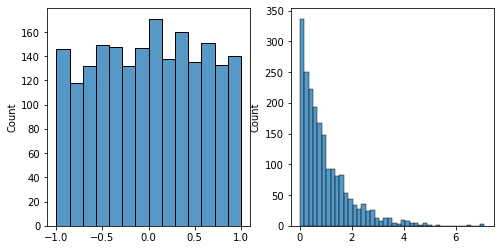

In [12]:
data.show_distribution(data.origin, 1, 2)